In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.cm import get_cmap

import os
import pickle

import float_data as flt

from dask import delayed

def get_abt(cov):
  # For finding ellipse parameters from covariance
  w, V = np.linalg.eig(cov)
  t = np.arctan2(V[..., 0, 1], V[..., 0, 0]) * (180 / np.pi)
  return (w[..., 0], w[..., 1], t)

Retrieve the profiles

In [2]:
data = flt.retrieve_profiles(timeRange = slice('2000-01', '2000-12'))
data

<xarray.DataArray 'thetao' (time: 12, lev: 30, n: 22194)>
dask.array<getitem, shape=(12, 30, 22194), dtype=float32, chunksize=(8, 30, 22194), chunktype=numpy.ndarray>
Coordinates:
    lat      (n) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * lev      (lev) float64 108.0 120.0 133.1 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (n) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
  * n        (n) MultiIndex
  - i        (n) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359 359
  - j        (n) int64 81 82 83 84 85 86 87 88 ... 132 133 134 135 136 137 138
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        mo: This variable is reported using a z* coordinate syste...
    long_name:      Sea Water Potential Temperature
    original_name:  mo: (variable_name: thetao)
    standard_name:  sea_water_potential_temperature
    units:          degC

Create a random sample of profiles

In [15]:
data_sampled = flt.random_sample(data, 100).persist()
(data_normalised, data_mean, data_std) = flt.normalise_data(data_sampled, 'N', return_inv=True)

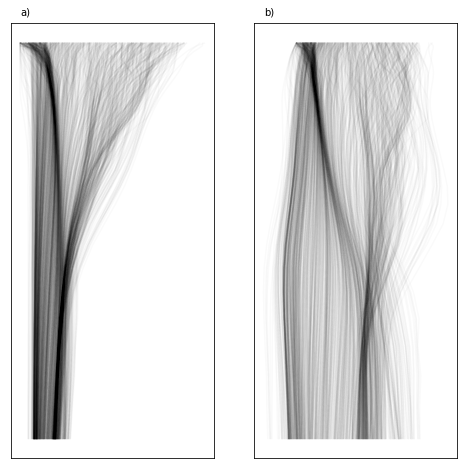

In [9]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(data_sampled.transpose(), -data_sampled['lev'], c=(0, 0, 0, 0.02))
axes[1].plot(data_normalised.transpose(), -data_sampled['lev'], c=(0, 0, 0, 0.02))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
fig.set_size_inches(8, 8)
axes[0].text(0.05,1.02,'a)',transform=axes[0].transAxes)
axes[1].text(0.05,1.02,'b)',transform=axes[1].transAxes)
plt.savefig('figures/demo-raw', dpi=300, bbox_inches='tight')
plt.show()

Train a PCA model on the data

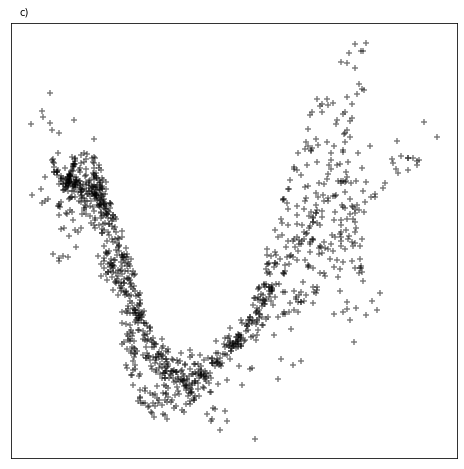

The profiles in PCA space, each point is a single profile


In [12]:
n_components = 2

pca = flt.train_pca(data_normalised, n_components)
data_pca = flt.pca_transform(data_normalised, pca)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), color=(0, 0, 0, 0.5), marker='+')
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(8, 8)
ax.text(0.02,1.02,'c)',transform=ax.transAxes)
plt.savefig('figures/demo-pca', dpi=300, bbox_inches='tight')

plt.show()
print('The profiles in PCA space, each point is a single profile')


Train a Gaussian mixture model on the transformed data

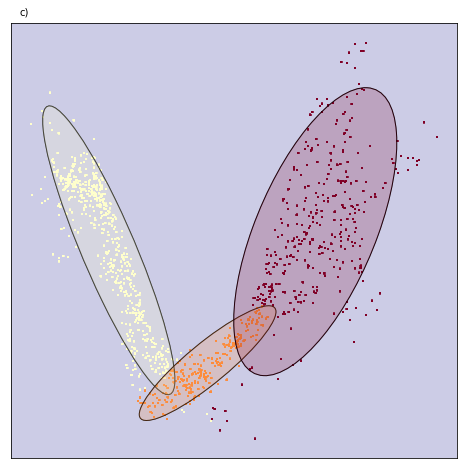

The learned GMM components.


In [14]:
n_classes = 3
gmm = flt.train_gmm(data_pca, n_classes)
data_classes = flt.pca_sort(flt.gmm_classify(data_pca, gmm), gmm)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), c=data_classes, alpha=1, s=5, cmap='YlOrRd', marker='+')


cmap = get_cmap('YlOrRd')

means = gmm.means_
inds = np.argsort(means[:, 0])
means = means[inds, :]

(As, Bs, Ts) = get_abt(gmm.covariances_[inds, :, :])


for (i, (a, b, t)) in enumerate(zip(As, Bs, Ts)):
  rgba = list(cmap(i / (n_classes - 1)))
  rgba[-1] = 0.2
  ax.add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=False))
  ax.add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=True, color=rgba))
ax.set_facecolor((0.8, 0.8, 0.9))
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.02,1.02,'c)',transform=ax.transAxes)

fig.set_size_inches(8, 8)
plt.savefig('figures/demo-gmm', dpi=300, bbox_inches='tight')

plt.show()
print('The learned GMM components.')

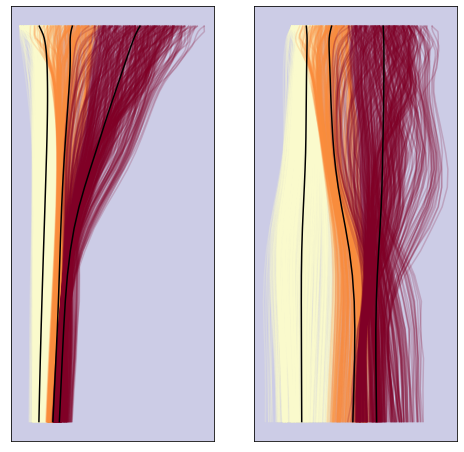

In [6]:
fig, axes = plt.subplots(1, 2)
cmap = get_cmap('YlOrRd')
for n in range(n_classes):
  rgba = list(cmap(n / (n_classes - 1)))
  rgba[-1] = 0.2
  axes[0].plot(data_sampled.isel(N = data_classes==n).transpose(), -data_sampled['lev'], c=rgba)
  axes[1].plot(data_normalised.isel(N = data_classes==n).transpose(), -data_sampled['lev'], c=rgba)
for n in range(n_classes):
  axes[0].plot(data_mean + (mean_profiles[n,:] * data_std), -data_sampled['lev'], c='black')
  axes[1].plot(mean_profiles[n,:], -data_sampled['lev'], c='black')

fig.set_size_inches(8, 8)
for ax in axes:
  
  ax.set_facecolor((0.8, 0.8, 0.9))
  ax.set_xticks([])
  ax.set_yticks([])
plt.savefig('figures/demo-class', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
import cartopy.crs as ccrs
data_raw = flt.retrieve_profiles(timeRange = slice('2000-01', '2000-12'), options={'raw':True})
data_c = flt.pca_sort(flt.gmm_classify(flt.pca_transform(flt.normalise_data(data_raw, ('i', 'j', 'time')), pca), gmm), gmm)
lats = data_c['lat'].values
lons = data_c['lon'].values
plt_data = data_c.values
alpha = np.logical_not(data_raw.isel(time=0, lev=-1).isnull().values)
plt_data[plt_data == -1] = 0

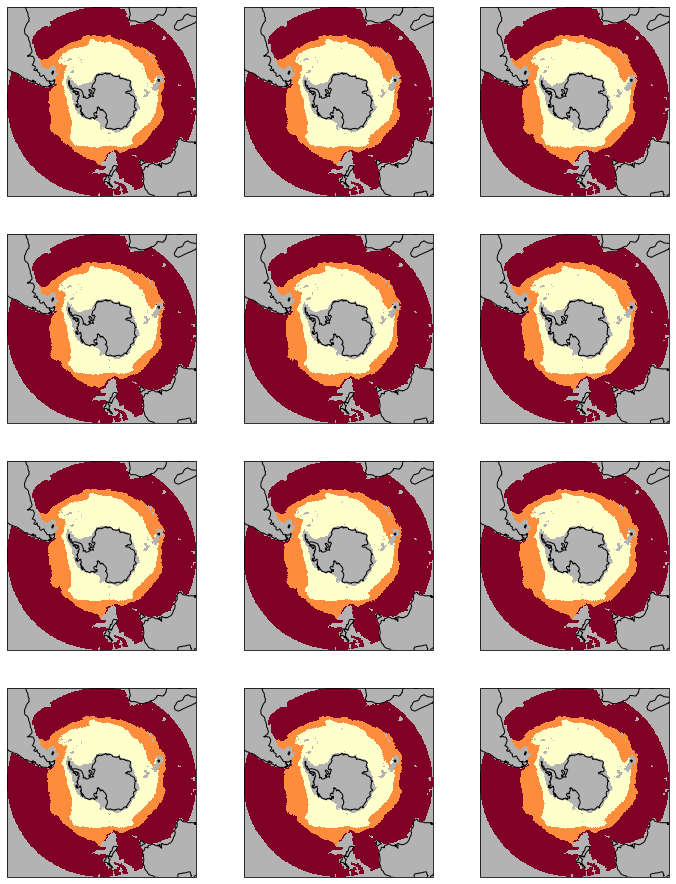

In [12]:
fig = plt.figure()
gs = fig.add_gridspec(4, 3)

for yr in range(np.size(plt_data, 0)):
  cmap = get_cmap('YlOrRd')
  ax = fig.add_subplot(gs[int(yr/3), yr % 3], projection=ccrs.SouthPolarStereo())
  ax.pcolormesh(lons, lats, plt_data[yr, :, :], transform=ccrs.PlateCarree(), alpha=alpha, cmap='YlOrRd') #, cmap='YlOrRd'
  try:
    # This will fail if cartopy is not installed properly
    ax.coastlines()
  except:
    pass
  ax.set_facecolor((0.7, 0.7, 0.7, 1))
fig.set_size_inches(12, 16)
plt.show()

In [9]:
np.shape(plt_data)

(12, 139, 360)

In [10]:
np.shape(alpha)

(22194,)